## Machine learning classifiers for predicting no-show appointments

This is a notebook to test different classifiers on the dataset from Kaggle (noshowappointments). The goal is to predict whether a patient will show up for an appointment or not.
The notebook goal is to create the best classifier possible, and to compare the results of different classifiers. Also, explainable methods are employed to understand the results of the classifiers as the classifiers are used in a medical context. The classifiers developed are not explained by their structure.

The classifiers are tested on the dataset from Kaggle (noshowappointments). The dataset contains information about 110527 medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row. The dataset is available at https://www.kaggle.com/joniarroba/noshowappointments.

The dataset has been cleaned and preprocessed in the notebook "eda-prep.ipynb". The cleaned dataset is saved in the file "cleaned_data.csv".

***

### Import libraries

In [38]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.metrics import accuracy_score, f1_score

from sklearn.inspection import PartialDependenceDisplay, partial_dependence

from imblearn.under_sampling import InstanceHardnessThreshold

from interpret.blackbox import LimeTabular
from interpret import show

In [ ]:
!git clone https://github.com/SauceCat/PDPbox.git
%cd PDPbox
!python setup.py install

In [49]:
import pdpbox
from pdpbox import pdp

### Prepare data (split, deal with imbalanced data)

In [2]:
df = pd.read_csv('data/cleaned_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110521 entries, 0 to 110520
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Gender                110521 non-null  int64
 1   Scholarship           110521 non-null  int64
 2   Hypertension          110521 non-null  int64
 3   Diabetes              110521 non-null  int64
 4   Alcoholism            110521 non-null  int64
 5   Handicap              110521 non-null  int64
 6   SMS_received          110521 non-null  int64
 7   Show                  110521 non-null  int64
 8   ScheduledHour         110521 non-null  int64
 9   ScheduledMonth        110521 non-null  int64
 10  AppointmentMonth      110521 non-null  int64
 11  AwaitingTimeDays      110521 non-null  int64
 12  ScheduledDayOfWeek    110521 non-null  int64
 13  AppointmentDayOfWeek  110521 non-null  int64
 14  AgeGroupInt           110521 non-null  int64
 15  NeighbourhoodInt      110521 non-n

In [3]:
X = df.drop(['Show'], axis=1)
y = df['Show']

In [4]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({1: 88207, 0: 22314})


In [5]:
iht = InstanceHardnessThreshold(random_state=42)
X_res, y_res = iht.fit_resample(X, y)

In [6]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 24367, 0: 22314})


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [10]:
print('X_train size: ', X_train.shape)
print('X_test size: ', X_test.shape)
print('y_train size: ', y_train.shape)
print('y_test size: ', y_test.shape)

X_train size:  (32676, 15)
X_test size:  (14005, 15)
y_train size:  (32676,)
y_test size:  (14005,)


In [11]:
print('y_train value counts: ', y_train.value_counts())
print('y_test value counts: ', y_test.value_counts())

y_train value counts:  1    17119
0    15557
Name: Show, dtype: int64
y_test value counts:  1    7248
0    6757
Name: Show, dtype: int64


### XGBoost

In [12]:
xgboost_cls = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=8,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)


xgboost_cls.fit(X_train, y_train)

y_pred = xgboost_cls.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: %.2f%%' % (f1 * 100.0))

Accuracy: 95.32%
F1 score: 95.31%


#### Feature importance

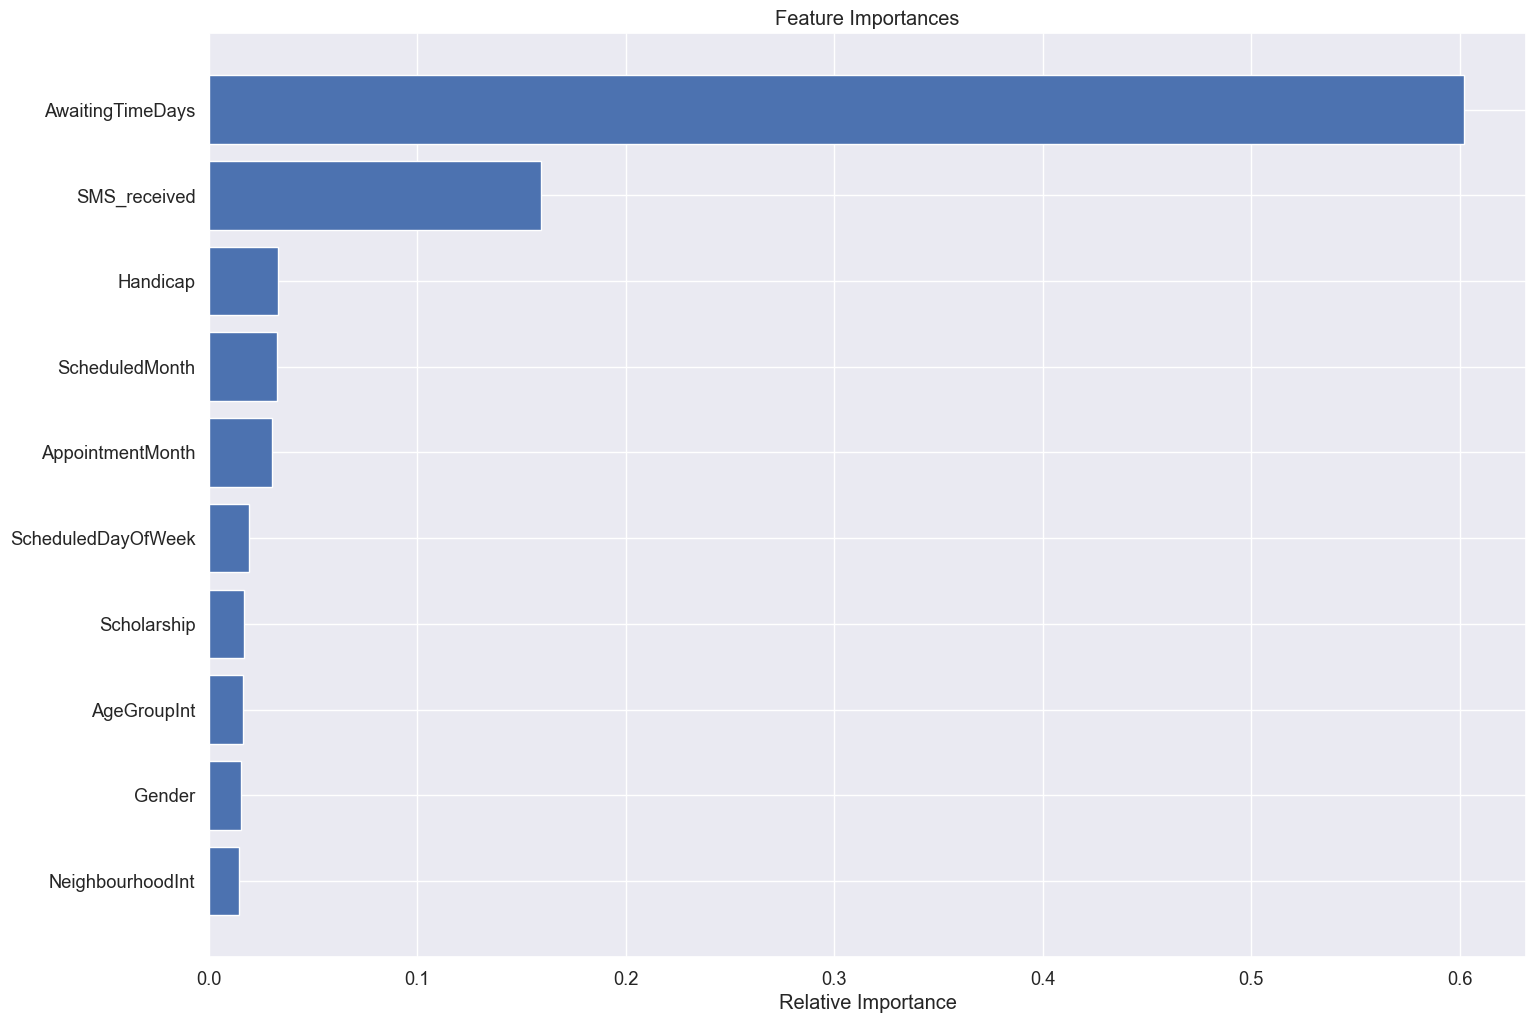

In [32]:
importances_xgboost = xgboost_cls.feature_importances_
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
indices = np.argsort(importances_xgboost)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_xgboost[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

### Random Forest

In [20]:
rf_cls = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=8,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
)

rf_cls.fit(X_train, y_train)

y_pred = rf_cls.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: %.2f%%' % (f1 * 100.0))

/opt/miniconda3/envs/lmappshow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy: 94.36%
F1 score: 94.34%


#### Feature importance

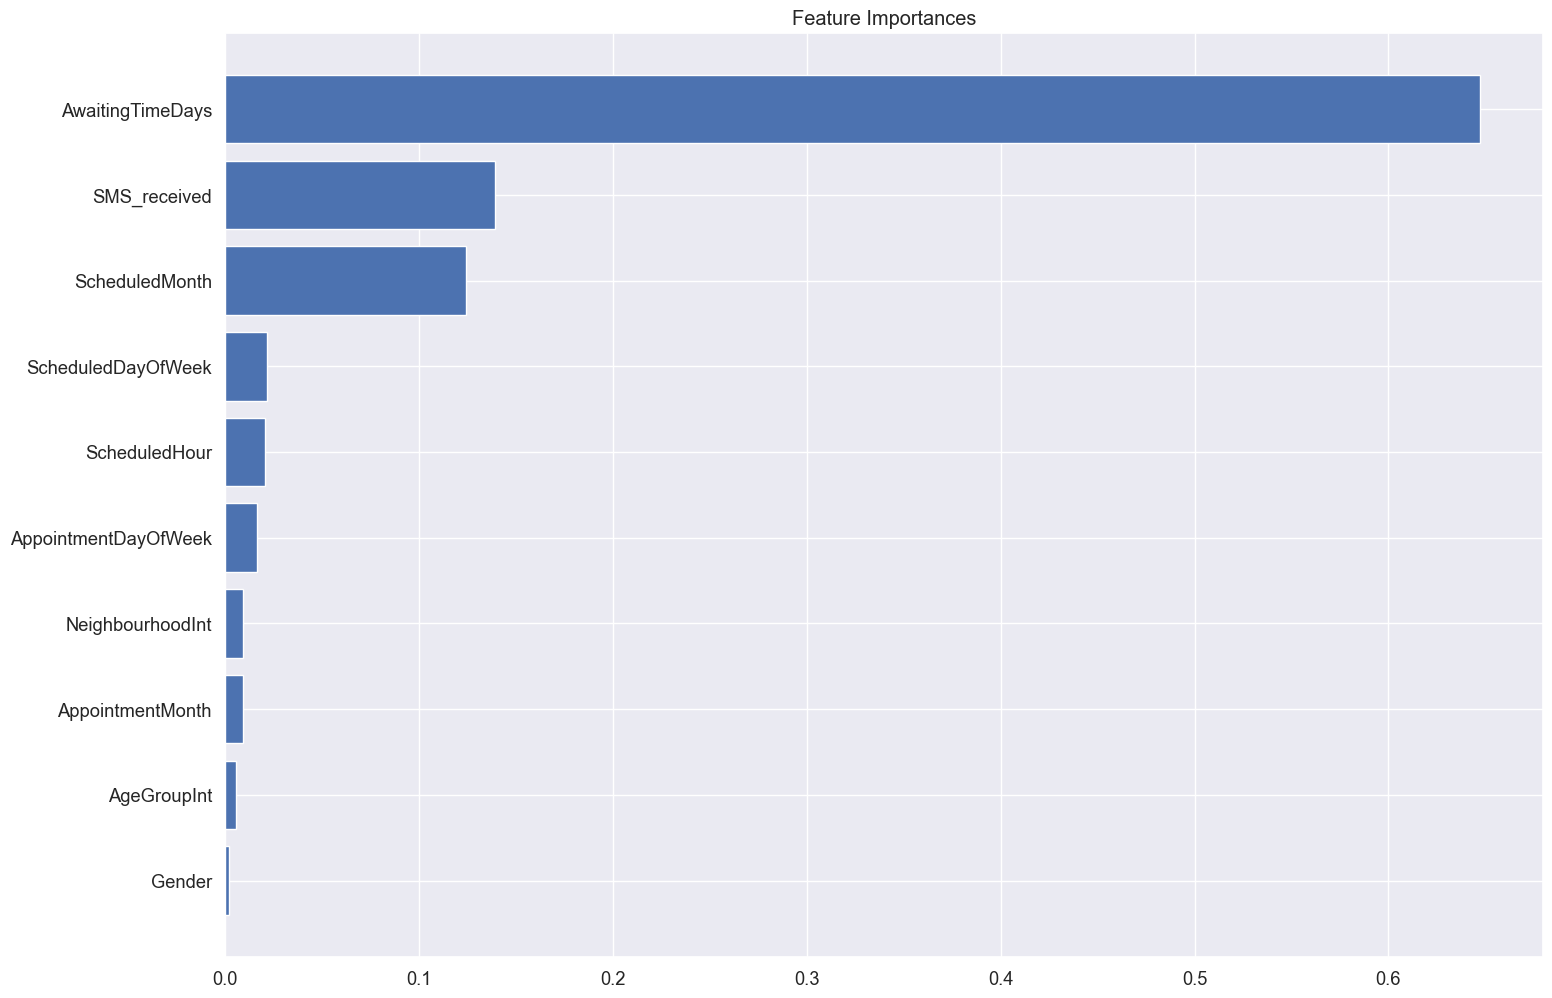

In [26]:
importances_rf = rf_cls.feature_importances_
# plot the feature importances and the feature names
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
# limit to ten features
indices = np.argsort(importances_rf)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_rf[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.show()

#### LIME 

In [66]:
lime = LimeTabular(
    model=rf_cls,
    data=X_train,
    random_state=1
)

lime_local = lime.explain_local(
    X_test[1020:],
    y_test[1020:],
    name='LIME'
)

show(lime_local)

### Gradient Boosting

In [27]:
gb_cls = GradientBoostingClassifier(
    max_depth=7,
    n_estimators=120,
    learning_rate=0.1,
    random_state=42
)

gb_cls.fit(X_train, y_train)

y_pred = gb_cls.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: %.2f%%' % (f1 * 100.0))

Accuracy: 95.31%
F1 score: 95.30%


#### Feature importance

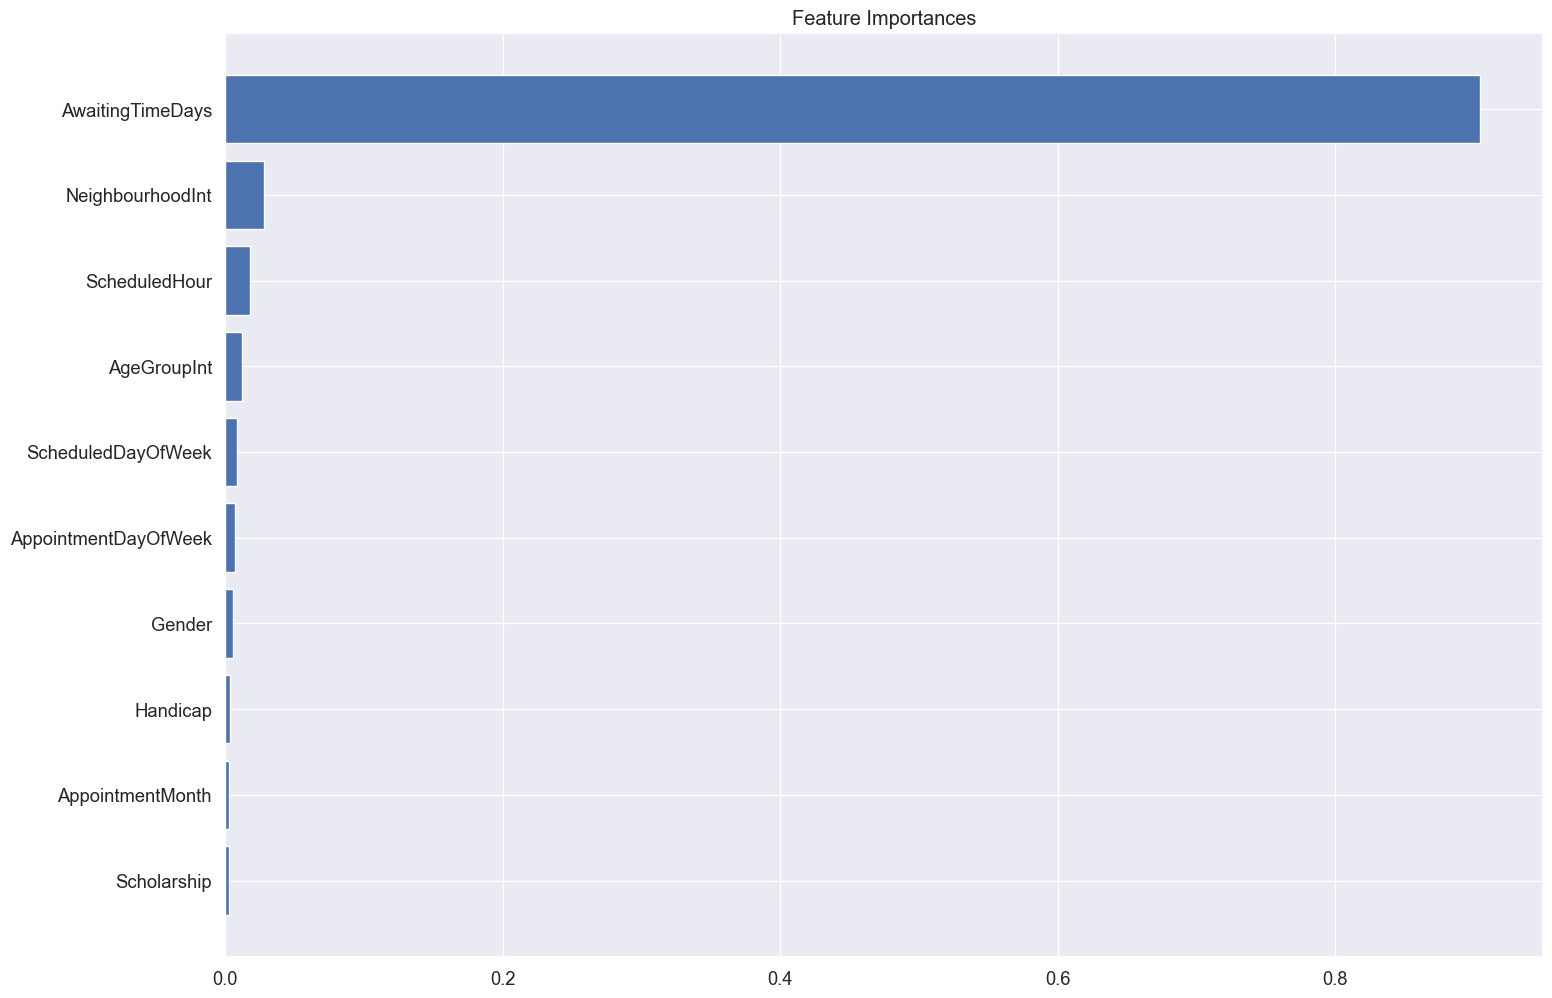

In [28]:
importances_gb = gb_cls.feature_importances_
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
indices = np.argsort(importances_gb)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_gb[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.show()

#### Partial Dependence Plots (PDPs)

Show the relationship between the target variable and features.


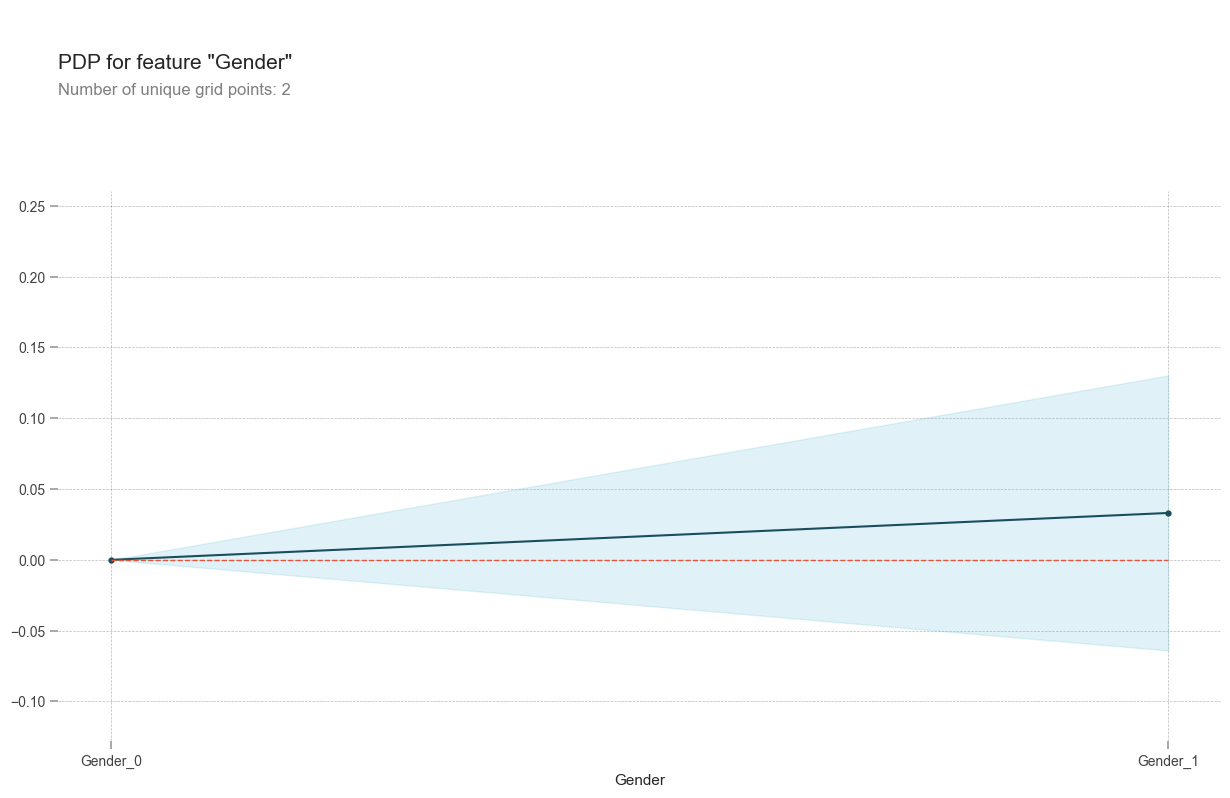

In [48]:
pdp_dist = pdp.pdp_isolate(model=gb_cls, dataset=X, model_features=X.columns, feature='Gender')
pdp.pdp_plot(pdp_dist, 'Gender')
plt.show()


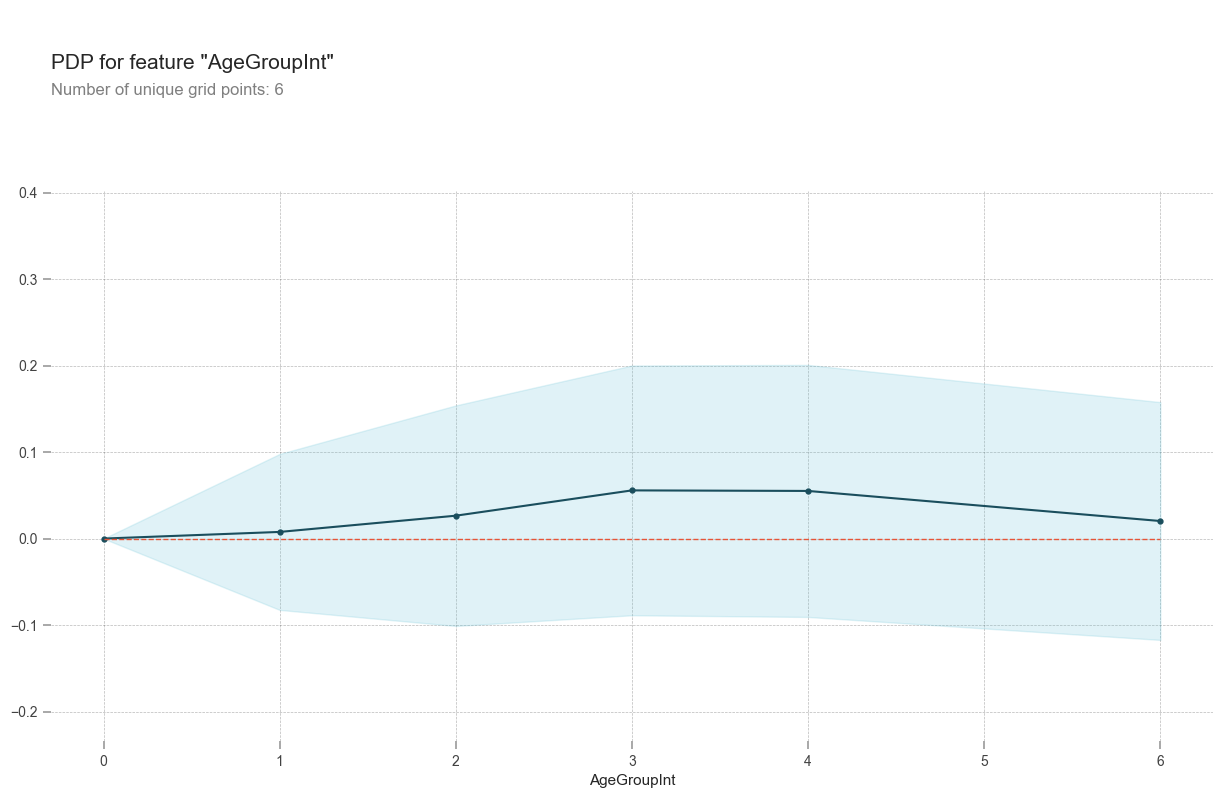

In [51]:
pdp_dist = pdp.pdp_isolate(model=gb_cls, dataset=X, model_features=X.columns, feature='AgeGroupInt')
pdp.pdp_plot(pdp_dist, 'AgeGroupInt')
plt.show()

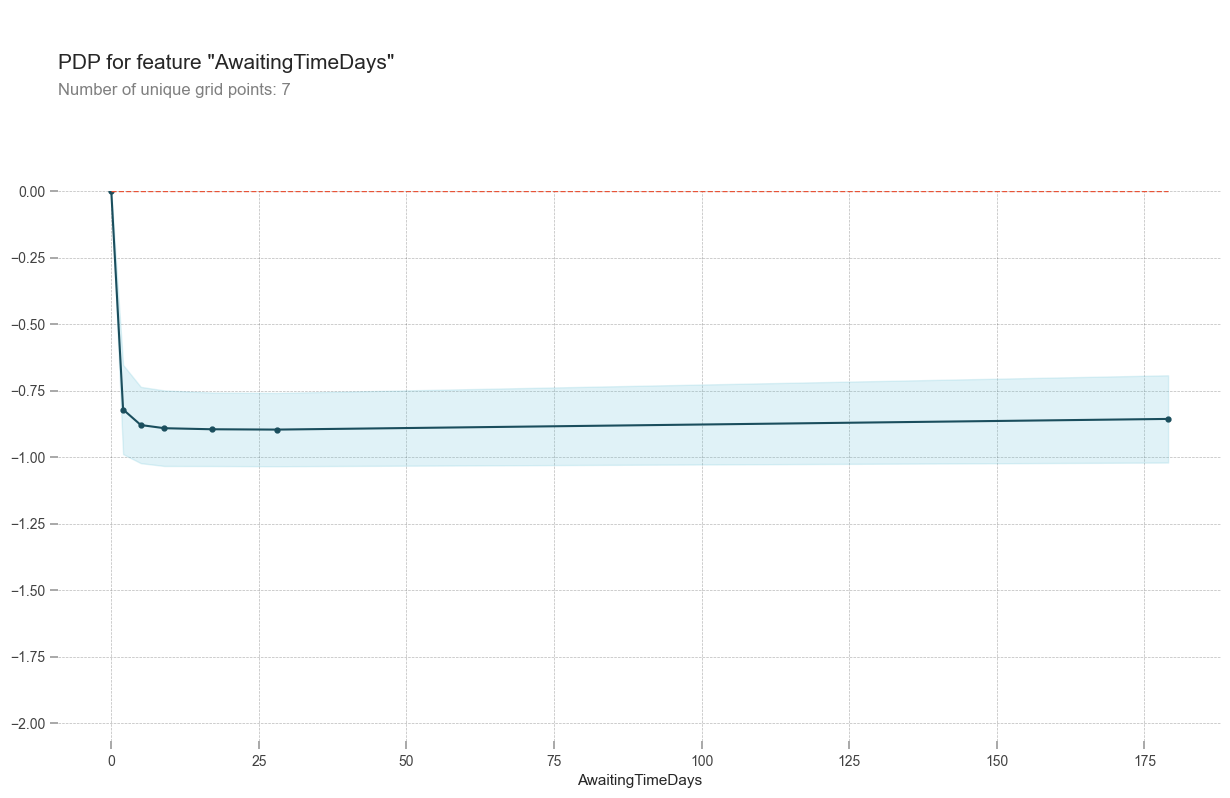

In [52]:
pdp_dist = pdp.pdp_isolate(model=gb_cls, dataset=X, model_features=X.columns, feature='AwaitingTimeDays')
pdp.pdp_plot(pdp_dist, 'AwaitingTimeDays')
plt.show()

### AdaBoost

In [16]:
ada = AdaBoostClassifier(n_estimators=100, random_state=101)

ada.fit(X_train, y_train)

y_pred = ada.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: %.2f%%' % (f1 * 100.0))

Accuracy: 94.31%
F1 score: 94.29%


#### Feature importance

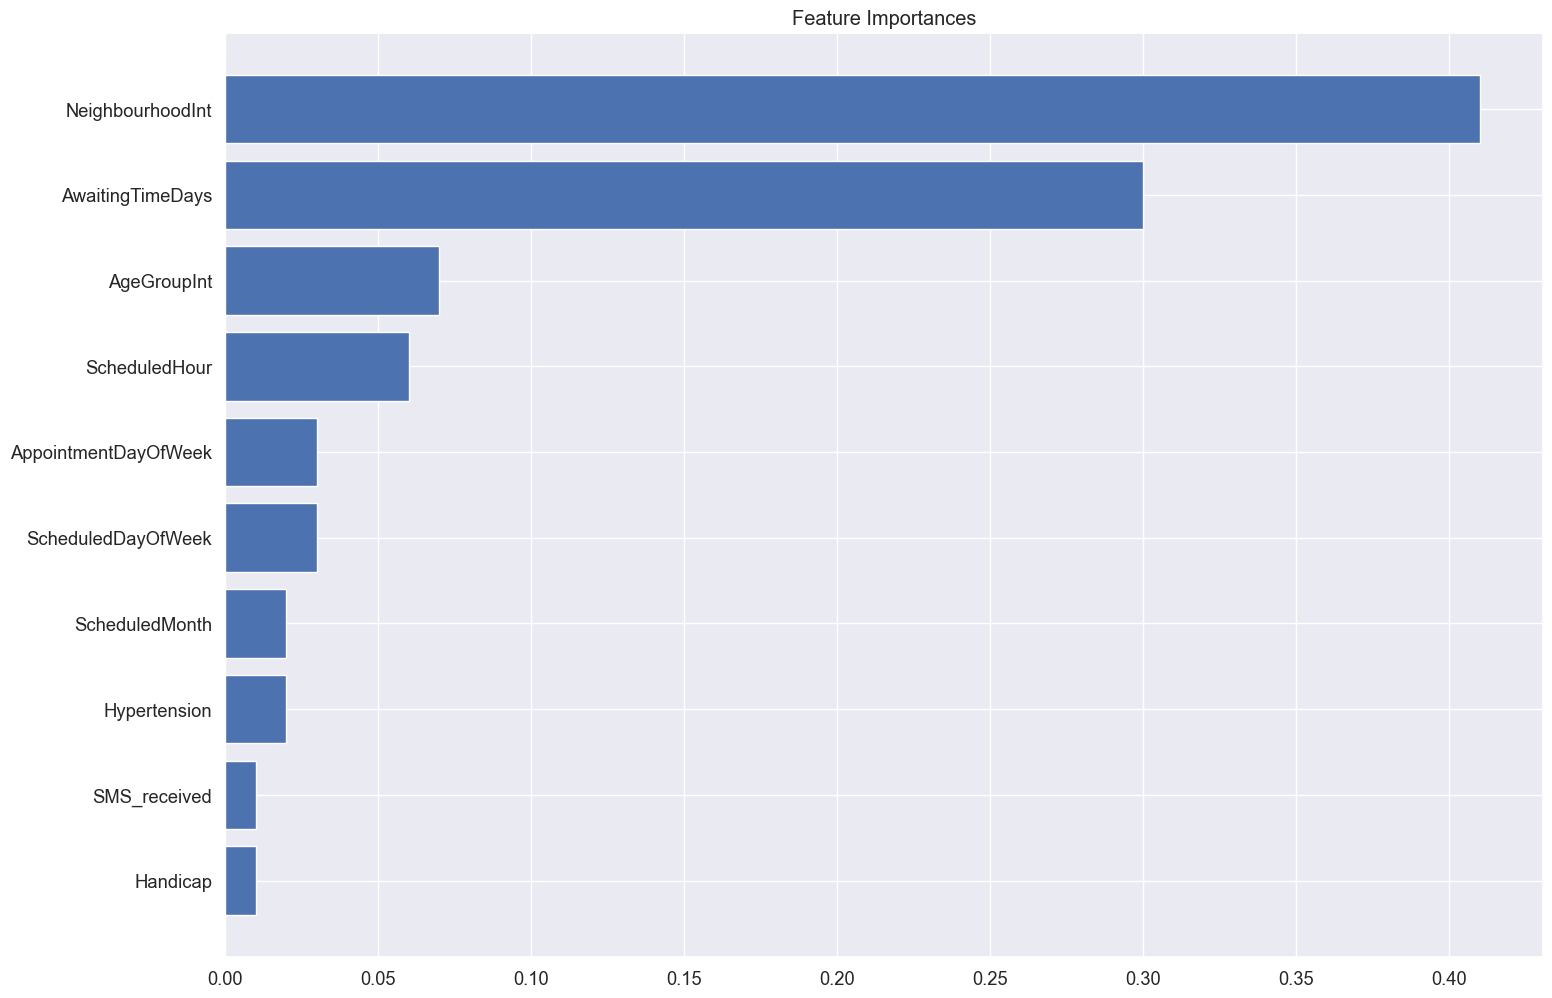

In [29]:
importances_ada = ada.feature_importances_
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
indices = np.argsort(importances_ada)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_ada[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.show()